## 1. Imports & Config.

In [244]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

data_dir = os.path.join(os.getcwd(), 'data')

obsid = '1342203292'  # observation id

level = 'level2_5'

lambda_um = 500

array = {250: 'PSW', 350: 'PMW', 500: 'PLW'}[lambda_um]

# possible types:
#   extd: extended-source calibrated (MJy/sr)
#   hires: extended-source calibrated, hi-res (Richardson-Lucy deconvolution, MJy/sr)
#   psrc: point-source calibrated (Jy/beam)

type = 'hires'

product = f'{type}{array}'

obs_dir = os.path.join(data_dir, obsid)
level_dir = os.path.join(obs_dir, level)
prod_dir = os.path.join(level_dir, product)

## 2. Load the Observation Context

In [245]:
# obs_fnames = os.listdir(obs_dir)
# level_fnames = os.listdir(level_dir)
# 
# obs_ctxts = [f for f in obs_fnames if f.endswith('.fits')]
# level_ctxts = [f for f in level_fnames if f.endswith('.fits')]
# 
# assert len(level_ctxts) == 1
# assert len(obs_ctxts) == 1
# 
# obs_ctxt = fits.open(os.path.join(obs_dir, obs_ctxts[0]))
# level_ctxt = fits.open(os.path.join(level_dir, level_ctxts[0]))

In [246]:
# print("Observation Context:")
# obs_ctxt.info()

In [247]:
# print("\n\nLevel Context:")
# level_ctxt.info()

## 3. Load Image Data

In [248]:
# each product directory contains a single .fits file
prod_fnames = os.listdir(prod_dir)
assert len(prod_fnames) == 1, "only one file expected"
assert prod_fnames[0].endswith('.fits'), "file should be in .fits format"

fits_filename = os.path.join(prod_dir, prod_fnames[0])

# open the only file in the directory
hdul = fits.open(fits_filename)  # Header Data Unit list
hdul.info()

Filename: C:\Users\Jonah\PycharmProjects\spire_blasttng_diff\data\1342203292\level2_5\hiresPLW\hspireplw1342203291_25hirespxmp_1462481003485.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     163   ()      
  1  image         1 ImageHDU        49   (1776, 1836)   float64   
  2  cfv           1 ImageHDU        47   (1776, 1836)   float64   
  3  coverage      1 ImageHDU        49   (1776, 1836)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   10R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   3R x 4C   [1K, 16A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   25R x 10C   [1K, 18A, 13A, 196A, 1L, 1K, 1L, 47A, 11A, 28A]   


## 4. Plot Images

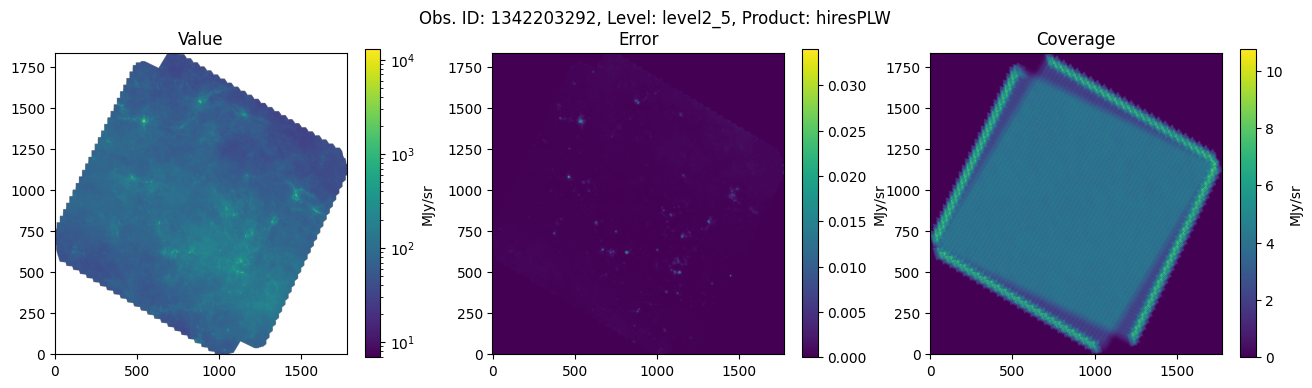

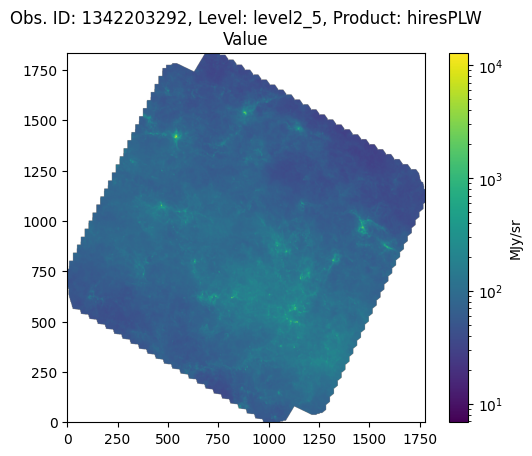

XTENSION= 'IMAGE   '           / Java FITS: Thu May 05 16:46:01 CEST 2016       
BITPIX  =                  -64                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                 1776                                                  
NAXIS2  =                 1836                                                  
PCOUNT  =                    0 / No extra parameters                            
GCOUNT  =                    1 / One group                                      
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used.   
COMMENT This FITS file may contain long string keyword values that are          
COMMENT continued over multiple keywords.  This convention uses the  '&'        
COMMENT character at the end of a string which is then continued                
COMMENT on subsequent keywords whose name = 'CONTINUE'.                         
          -------------- Her

In [249]:
log_norm = colors.LogNorm()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(16, 4))
fig.suptitle(f"Obs. ID: {obsid}, Level: {level}, Product: {product}")

img = hdul[1].data
ax1.set_title("Value")
fig1 = ax1.imshow(img, cmap='viridis', norm=log_norm, origin='lower')
plt.colorbar(fig1, ax=ax1, label="MJy/sr")

error = hdul[2].data
ax2.set_title("Error")
fig2 = ax2.imshow(error, cmap='viridis', origin='lower')
plt.colorbar(fig2, ax=ax2, label="MJy/sr")

coverage = hdul[3].data
ax3.set_title("Coverage")
fig3 = ax3.imshow(coverage, cmap='viridis', origin='lower')
plt.colorbar(fig3, ax=ax3, label="MJy/sr")

plt.show()

plt.title(f"Obs. ID: {obsid}, Level: {level}, Product: {product}\nValue")
plt.imshow(img, cmap='viridis', norm=log_norm, origin='lower')
plt.colorbar(label="MJy/sr")
plt.show()

hdul[1].header

In [314]:

hdr = hdul[1].header

assert hdr['BUNIT'] == 'MJy/sr'  # Unit of the data      
assert hdr['CTYPE1'] == 'RA---TAN'  # WCS: Projection type axis 1, default="LINEAR"
assert hdr['CTYPE2'] == 'DEC--TAN'  # WCS: Projection type axis 1, default="LINEAR"
assert hdr['equinox'] == 2000.0  # WCS: Equinox, unit=Duration
assert hdr['CROTA2'] == 0.0  # The Rotation angle

x_pixel_count = hdr['NAXIS1']
y_pixel_count = hdr['NAXIS2']

x_center_pixel = hdr['CRPIX1']
y_center_pixel = hdr['CRPIX2']

x_ref_pixel_coord = hdr['CRVAL1'] * u.deg
y_ref_pixel_coord = hdr['CRVAL2'] * u.deg

x_delta = hdr['CDELT1'] * u.deg
y_delta = hdr['CDELT2'] * u.deg

hdul.close()  # We now have everything we need

In [315]:
import astropy.coordinates as coords
def closest_spire_value(coord: coords.SkyCoord):
    ra_offset_deg = coord.ra - x_ref_pixel_coord
    dec_offset_deg = coord.dec - y_ref_pixel_coord
    
    x_offset_px = ra_offset_deg / x_delta
    y_offset_px = dec_offset_deg / y_delta
    
    x_idx = int(x_center_pixel + x_offset_px)
    y_idx = int(y_center_pixel + y_offset_px)
    
    print(y_idx, x_idx)
    
    return img[y_idx, x_idx]

In [316]:
rcw92_coord = SkyCoord(ra=229.66292*u.deg, dec=-56.64694*u.deg)
# closest_spire_value(rcw92_coord)

ra_offset_deg = rcw92_coord.ra - x_ref_pixel_coord
dec_offset_deg = rcw92_coord.dec - y_ref_pixel_coord

x_offset_px = ra_offset_deg / x_delta
y_offset_px = dec_offset_deg / y_delta

x_idx = int(x_center_pixel + x_offset_px)
y_idx = int(y_center_pixel + y_offset_px)

print(y_idx, x_idx)

img[y_idx, x_idx]

1415 329


np.float64(120.47590227104297)

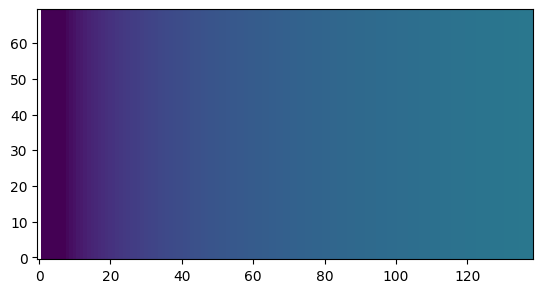

In [289]:


ra_min = 230.8  # degrees
ra_max = 232.2  # degrees
ra_width = ra_max - ra_min

dec_min= -56.6  # degrees
dec_max = -55.9  # degrees
dec_height = dec_max - dec_min

x_resolution = 0.01  # degrees
y_resolution = 0.01  # degrees

coords = []
for y_bin in range(int(dec_height / y_resolution)):
    row = []
    for x_bin in range(int(ra_width / x_resolution)):
        row.append(x_bin)
    coords.append(row)
coords = np.array(coords)

plt.imshow(coords, cmap='viridis', norm=log_norm, origin='lower')
plt.show()

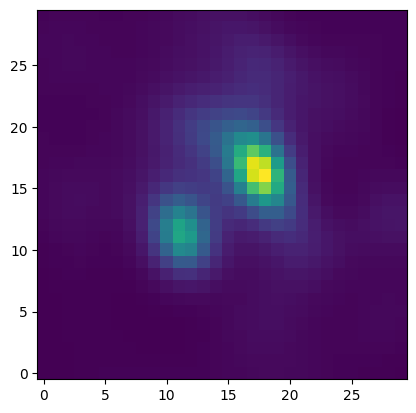

np.float64(12377.506022900398)

In [339]:
cropped = img[1400:1430, 525:555]
plt.imshow(cropped, cmap='viridis', origin='lower')
plt.show()

peak = img[1417, 542]
peak